In [137]:
import numpy as np
from matplotlib import pyplot as pl

import scipy.io.wavfile as wav
from scikits.talkbox.features import mfcc

%matplotlib inline

import os
BASE_DIR = 'vowels/'
files = os.listdir(BASE_DIR)

import mlp_backprop_momentum as mlp
reload(mlp)
import k_fold_cross_validation as cv
reload(cv)

<module 'k_fold_cross_validation' from 'k_fold_cross_validation.pyc'>

# 7.1

In [138]:
nafFiles = []
namFiles = []

# Get all natural female and male wav files by itering all the files' names.
# The first value of each array's elements is the simple rate, while the second one is the values.
for f in files:
    if f.startswith("naf"):
        nafFiles.append(wav.read(BASE_DIR + f))
    if f.startswith("nam"):
        namFiles.append(wav.read(BASE_DIR + f))

In [139]:
nafCeps = []
for f in nafFiles:
    nafCeps.append(mfcc(f[1], fs=f[0])[0])

namCeps = []
for f in namFiles:
    namCeps.append(mfcc(f[1], fs=f[0])[0])

Ici, pour chaque fichier, plutôt que de garder toutes les valeurs, on applatit les valeurs pour ne garder que la moyenne afin d'avoir des temps de calculs moins longs.

In [140]:
nafMeanCeps = []
for c in nafCeps:
    nafMeanCeps.append(np.mean(c, axis=0))

In [141]:
namMeanCeps = []
for c in namCeps:
    namMeanCeps.append(np.mean(c, axis=0))

On crée le dataset à partir des valeurs de mfcc, on choisit 1 pour les femmes et -1 pour les hommes.

In [142]:
dsf = np.array(map(lambda x: np.append(x, 1), nafMeanCeps))
dsm = np.array(map(lambda x: np.append(x, -1), namMeanCeps))
dataset = np.append(dsf, dsm, axis=0)

In [143]:
N_INITS = 10
EPOCHS = 100
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

In [144]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print 'Testing', h, 'neurons...'
    nn = mlp.MLP([13,h,2], 'tanh')
    for i in np.arange(N_INITS):                                        # looping the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataset[:,0:13], dataset[:,13:15]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


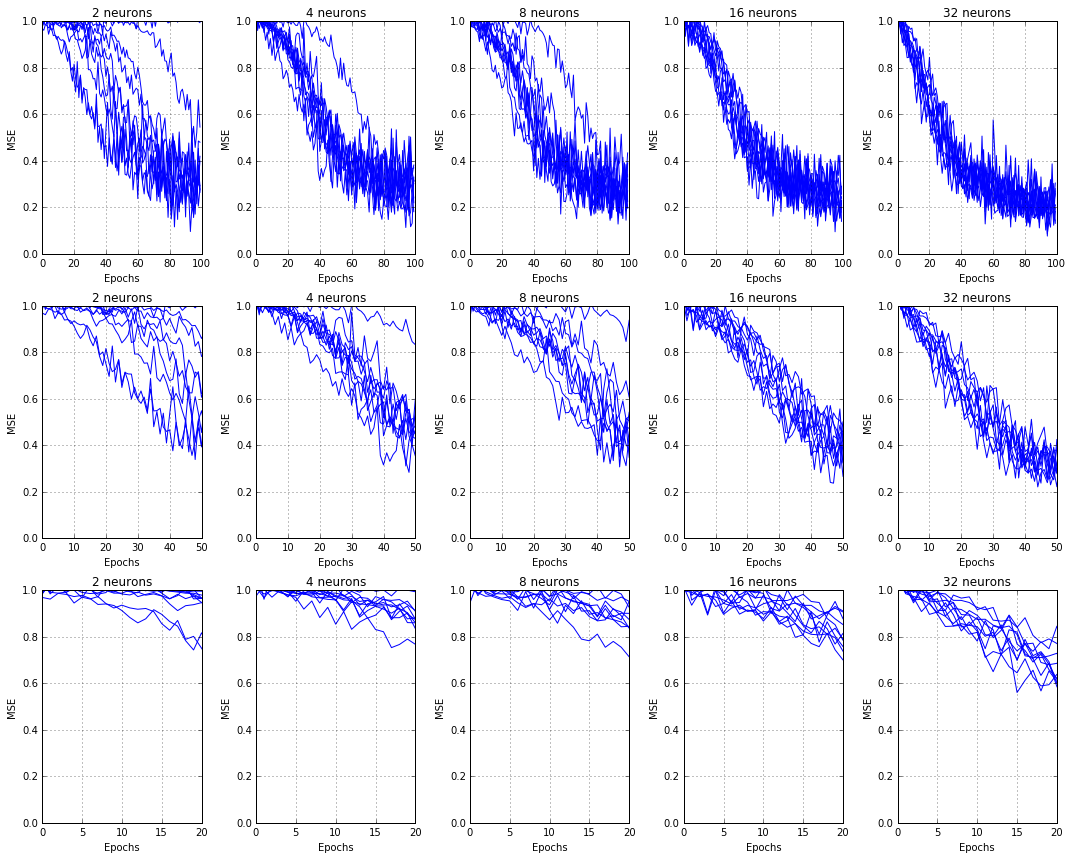

In [145]:
pl.figure(figsize=(15,12))
p_count = 0
for lim in [100, 50, 20]:
    for n in np.arange(MSE.shape[0]):
        p_count += 1
        pl.subplot(3,MSE.shape[0], p_count)
        for i in np.arange(MSE.shape[1]):
            pl.plot(MSE[n,i,:], c='b')
        pl.ylim(0,1)
        pl.xlim(0,lim)
        pl.xlabel('Epochs')
        pl.ylabel('MSE')
        pl.title(str(N_NEURONS[n]) + ' neurons')
        pl.grid()
pl.tight_layout()

Ces graphs montrent qu'après environ 50 epochs l'amélioration n'est pas substentielle et qu'il n'est pas nécessaire d'avoir plus de 8 neurones pour avoir des résultats corrects. Par contre, avec un faible nombre d'epochs, l'impact du nombre de neurones est plus grand.

## Exploring the number of hidden neurons

In [146]:
EPOCHS = [20, 50, 100]
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 30, 40, 50]

In [147]:
MSE_train = np.zeros((len(N_NEURONS), len(EPOCHS), N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), len(EPOCHS), N_TESTS))

for i_e, e in enumerate(EPOCHS):                                            # looping the number of epochs
    print 'Testing with', e, 'epochs...'
    for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
        print '\tTesting', h, 'neurons...'
        nn = mlp.MLP([13,h,1], 'tanh')
        for i in np.arange(N_TESTS):                                        # looping the tests
            temp1, temp2 = cv.k_fold_cross_validation(nn,
                                                      dataset,
                                                      k=K,
                                                      learning_rate=LEARNING_RATE,
                                                      momentum=MOMENTUM,
                                                      epochs=e)
            MSE_train[i_h, i_e, i] = temp1
            MSE_test[i_h, i_e, i] = temp2

Testing with 20 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...
Testing with 50 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...
Testing with 100 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...


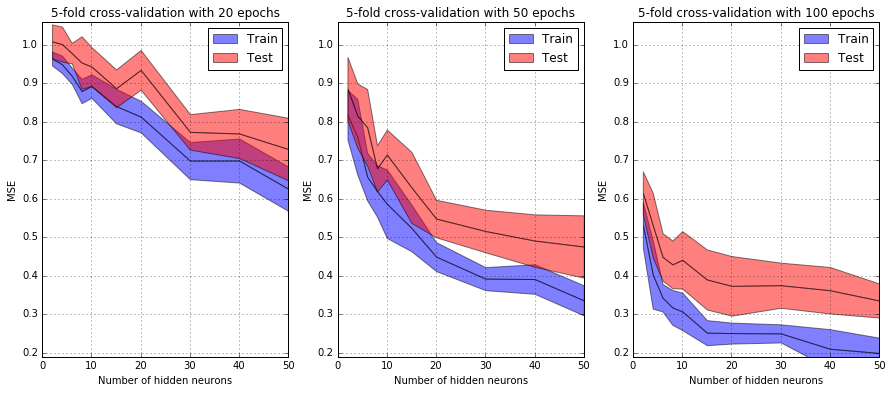

In [148]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

pl.figure(figsize=(15,6))
for i_e, e in enumerate(EPOCHS):
    pl.subplot(1,3,i_e+1)
    pl.fill_between(N_NEURONS, MSE_train_mean[:,i_e], MSE_train_mean[:,i_e]+MSE_train_sd[:,i_e], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(N_NEURONS, MSE_train_mean[:,i_e], MSE_train_mean[:,i_e]-MSE_train_sd[:,i_e], facecolor='blue', alpha=0.5)
    pl.fill_between(N_NEURONS, MSE_test_mean[:,i_e], MSE_test_mean[:,i_e]+MSE_test_sd[:,i_e], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(N_NEURONS, MSE_test_mean[:,i_e], MSE_test_mean[:,i_e]-MSE_test_sd[:,i_e], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,1.05*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of hidden neurons')
    pl.title(str(K)+'-fold cross-validation with '+str(e)+' epochs')
    pl.legend()
    pl.grid()

On voit que quand le nombre d'epochs est faible, le training set donne des résultats proche du testing set et que plus le nombre de neurones augmente plus les résultats sont bons. Par contre avec suffisament d'epochs l'augmentation du nombres de neurones a peu d'effet et le testing set.

## Exploring the number of epochs and the number of hidden neurons at the same time

In [149]:
EPOCHS = 100

In [150]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print '\tTesting', h, 'neurons...'
    nn = mlp.MLP([13,h,1], 'tanh')
    temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,
                                                        dataset,
                                                        k=K,
                                                        learning_rate=LEARNING_RATE,
                                                        momentum=MOMENTUM,
                                                        epochs=EPOCHS)
    MSE_train[i_h, :] = temp1
    MSE_test[i_h, :] = temp2

	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...


In [151]:
min(np.min(MSE_train), np.min(MSE_test))

0.17514777128765274

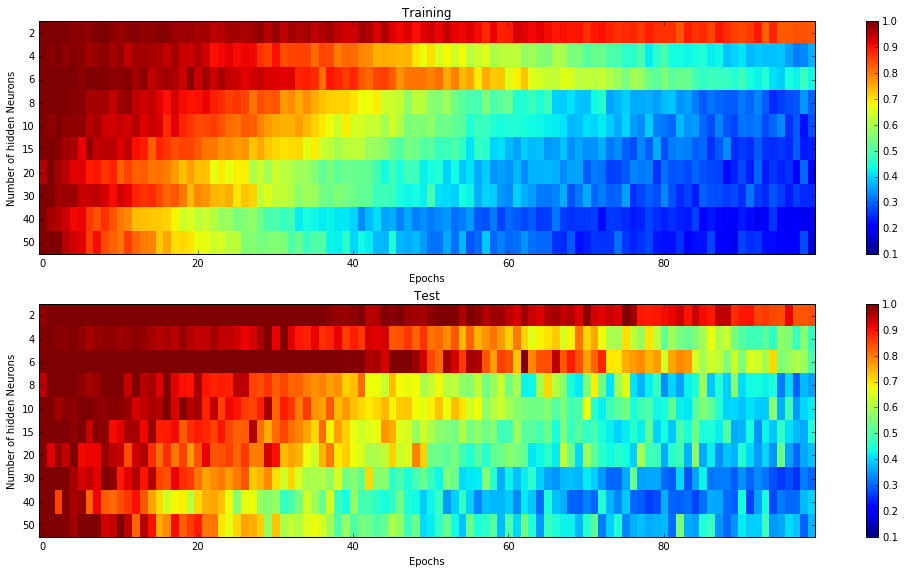

In [152]:
#v_min = min(np.min(MSE_train), np.min(MSE_test))
v_min = 0.1   # tune these values to enhance visualization
v_max = 1

pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train, vmin=v_min, vmax=v_max, aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test, vmin=v_min, vmax=v_max, aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

Sans surprise par rapport aux graphs précédents, on voit que plus le nombre d'epochs et de neurones augmente, plus l'erreur est faible.

## The final model

In [153]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataset,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=80,
                                                          threshold=0.0)

In [154]:
print 'MSE training: ', MSE_train
print 'MSE test: ', MSE_test
print 'Confusion matrix:'
print conf_mat

MSE training:  0.209005711238
MSE test:  0.332325841541
Confusion matrix:
[[ 35.   1.]
 [  8.  28.]]


In [158]:
acc = (conf_mat[0][0] + conf_mat[1][1]) / (conf_mat[0][0] + conf_mat[0][1] +conf_mat[1][0] + conf_mat[1][1])
F1 = 2 * conf_mat[0][0] / (2 * conf_mat[0][0] + conf_mat[0][1] + conf_mat[1][0])
print acc
print F1

0.875
0.886075949367


Le fait que l'erreur est basse signifie que les données sont faciles à différencier, ce qui semble normal entre une voix d'homme et de femme.

# 7.2

In [159]:
nkFiles = []

for f in files:
    if f.startswith("nk"):
        nkFiles.append(wav.read(BASE_DIR + f))

In [160]:
nkCeps = []
for f in nkFiles:
    nkCeps.append(mfcc(f[1], fs=f[0])[0])

In [161]:
nkMeanCeps = []
for c in nkCeps:
    nkMeanCeps.append(np.mean(c, axis=0))

In [162]:
dsf = np.array(map(lambda x: np.append(x, 1), nkMeanCeps))
dsm = np.array(map(lambda x: np.append(x, -1), namMeanCeps))
dataset = np.append(dsf, dsm, axis=0)

In [163]:
N_INITS = 10
EPOCHS = 100
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

In [164]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print 'Testing', h, 'neurons...'
    nn = mlp.MLP([13,h,2], 'tanh')
    for i in np.arange(N_INITS):                                        # looping the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataset[:,0:13], dataset[:,13:15]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


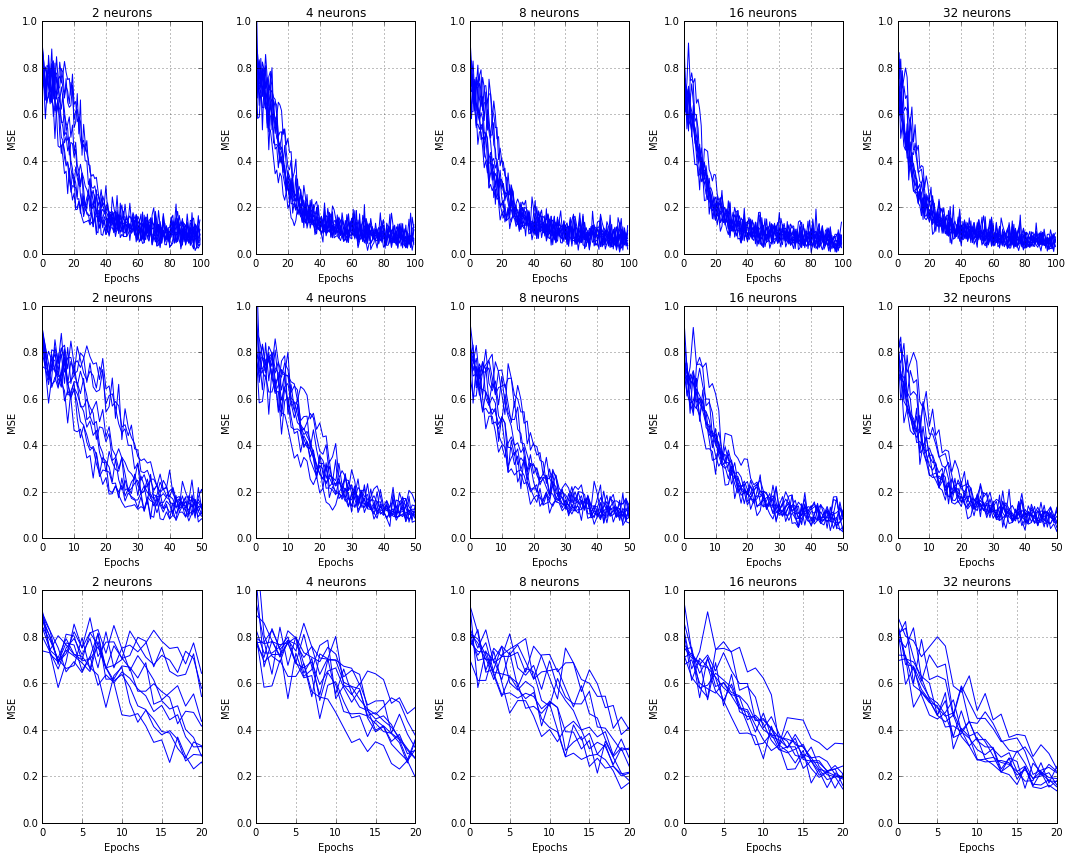

In [165]:
pl.figure(figsize=(15,12))
p_count = 0
for lim in [100, 50, 20]:
    for n in np.arange(MSE.shape[0]):
        p_count += 1
        pl.subplot(3,MSE.shape[0], p_count)
        for i in np.arange(MSE.shape[1]):
            pl.plot(MSE[n,i,:], c='b')
        pl.ylim(0,1)
        pl.xlim(0,lim)
        pl.xlabel('Epochs')
        pl.ylabel('MSE')
        pl.title(str(N_NEURONS[n]) + ' neurons')
        pl.grid()
pl.tight_layout()

On voit ici que le dataset doit être facile à différencier, puisqu'avec seulement 4 neurones et environ 50 epochs on obtient déjà de très bon résultats.

## Exploring the number of hidden neurons

In [166]:
EPOCHS = [20, 50, 100]
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 30, 40, 50]

In [167]:
MSE_train = np.zeros((len(N_NEURONS), len(EPOCHS), N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), len(EPOCHS), N_TESTS))

for i_e, e in enumerate(EPOCHS):                                            # looping the number of epochs
    print 'Testing with', e, 'epochs...'
    for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
        print '\tTesting', h, 'neurons...'
        nn = mlp.MLP([13,h,1], 'tanh')
        for i in np.arange(N_TESTS):                                        # looping the tests
            temp1, temp2 = cv.k_fold_cross_validation(nn,
                                                      dataset,
                                                      k=K,
                                                      learning_rate=LEARNING_RATE,
                                                      momentum=MOMENTUM,
                                                      epochs=e)
            MSE_train[i_h, i_e, i] = temp1
            MSE_test[i_h, i_e, i] = temp2

Testing with 20 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...
Testing with 50 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...
Testing with 100 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...


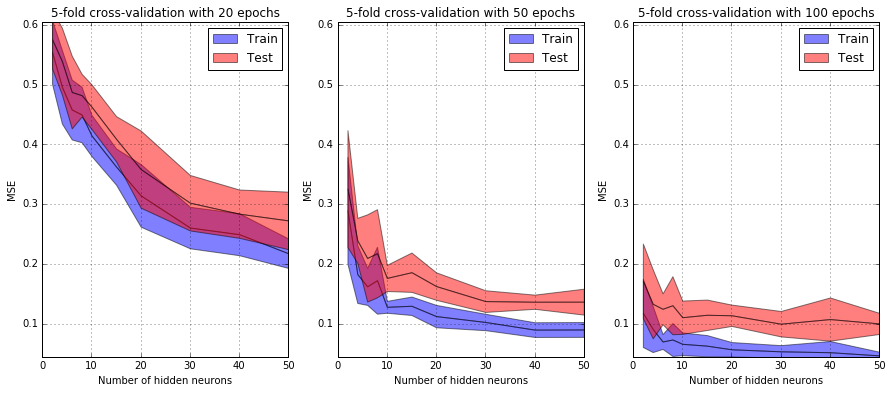

In [168]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

pl.figure(figsize=(15,6))
for i_e, e in enumerate(EPOCHS):
    pl.subplot(1,3,i_e+1)
    pl.fill_between(N_NEURONS, MSE_train_mean[:,i_e], MSE_train_mean[:,i_e]+MSE_train_sd[:,i_e], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(N_NEURONS, MSE_train_mean[:,i_e], MSE_train_mean[:,i_e]-MSE_train_sd[:,i_e], facecolor='blue', alpha=0.5)
    pl.fill_between(N_NEURONS, MSE_test_mean[:,i_e], MSE_test_mean[:,i_e]+MSE_test_sd[:,i_e], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(N_NEURONS, MSE_test_mean[:,i_e], MSE_test_mean[:,i_e]-MSE_test_sd[:,i_e], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,1.05*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of hidden neurons')
    pl.title(str(K)+'-fold cross-validation with '+str(e)+' epochs')
    pl.legend()
    pl.grid()

Le troisième graphe montre bien que le nombre de neurones n'influe presque pas sur les résultats puisque l'erreur reste constante.

## Exploring the number of epochs and the number of hidden neurons at the same time

In [169]:
EPOCHS = 100

In [170]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print '\tTesting', h, 'neurons...'
    nn = mlp.MLP([13,h,1], 'tanh')
    temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,
                                                        dataset,
                                                        k=K,
                                                        learning_rate=LEARNING_RATE,
                                                        momentum=MOMENTUM,
                                                        epochs=EPOCHS)
    MSE_train[i_h, :] = temp1
    MSE_test[i_h, :] = temp2

	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...


In [171]:
min(np.min(MSE_train), np.min(MSE_test))

0.039326273417708203

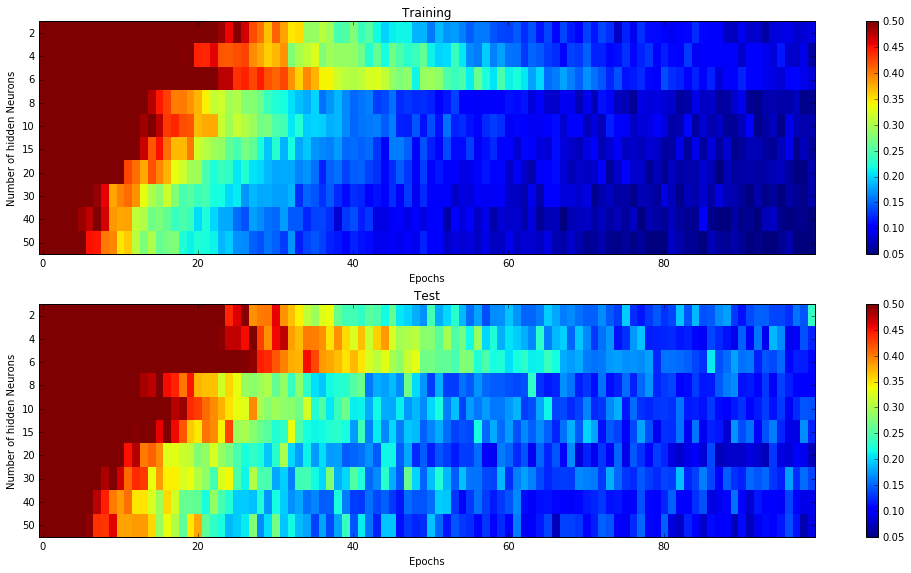

In [172]:
#v_min = min(np.min(MSE_train), np.min(MSE_test))
v_min = 0.05   # tune these values to enhance visualization
v_max = 0.5

pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train, vmin=v_min, vmax=v_max, aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test, vmin=v_min, vmax=v_max, aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

La séparation entre la zone rouge et la zone blue est très nette, ce qui signifie qu'il n'y a peu de faux positifs.

## The final model

In [173]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataset,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=80,
                                                          threshold=0.0)

In [174]:
print 'MSE training: ', MSE_train
print 'MSE test: ', MSE_test
print 'Confusion matrix:'
print conf_mat

MSE training:  0.0586194056402
MSE test:  0.112639655347
Confusion matrix:
[[ 107.    1.]
 [   4.   32.]]


In [175]:
acc = (conf_mat[0][0] + conf_mat[1][1]) / (conf_mat[0][0] + conf_mat[0][1] +conf_mat[1][0] + conf_mat[1][1])
F1 = 2 * conf_mat[0][0] / (2 * conf_mat[0][0] + conf_mat[0][1] + conf_mat[1][0])
print acc
print F1

0.965277777778
0.977168949772


Les résultats obtenus sont vraiment excellents, ce qui montre bien qu'il est facile de différencier une voix d'homme adulte d'une voix d'enfant.

# 7.3

In [176]:
dsf = np.array(map(lambda x: np.append(x, 1), nafMeanCeps))
dsm = np.array(map(lambda x: np.append(x, -1), nkMeanCeps))
dataset = np.append(dsf, dsm, axis=0)

In [177]:
N_INITS = 10
EPOCHS = 100
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

In [178]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print 'Testing', h, 'neurons...'
    nn = mlp.MLP([13,h,2], 'tanh')
    for i in np.arange(N_INITS):                                        # looping the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataset[:,0:13], dataset[:,13:15]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


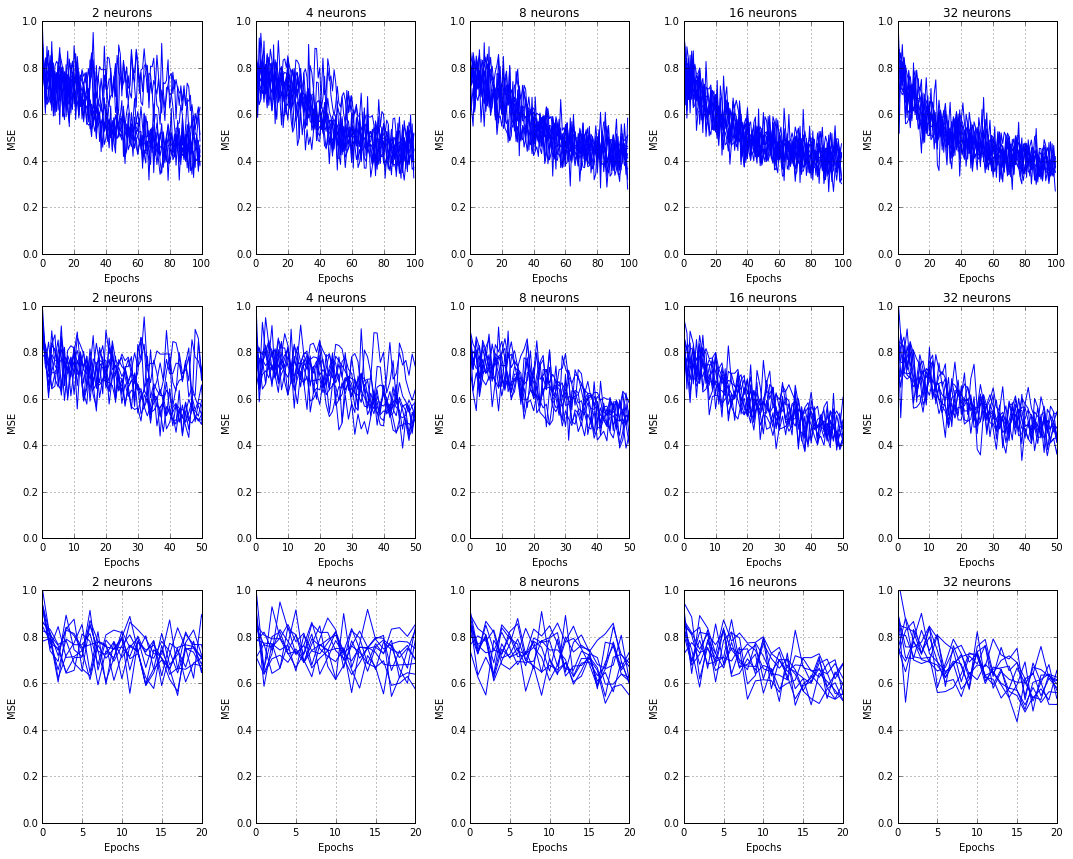

In [179]:
pl.figure(figsize=(15,12))
p_count = 0
for lim in [100, 50, 20]:
    for n in np.arange(MSE.shape[0]):
        p_count += 1
        pl.subplot(3,MSE.shape[0], p_count)
        for i in np.arange(MSE.shape[1]):
            pl.plot(MSE[n,i,:], c='b')
        pl.ylim(0,1)
        pl.xlim(0,lim)
        pl.xlabel('Epochs')
        pl.ylabel('MSE')
        pl.title(str(N_NEURONS[n]) + ' neurons')
        pl.grid()
pl.tight_layout()

On voit que les graphs sont relativement plats, ce qui signifie que le nombre d'epochs n'a pas une grande influence. A nouveau, vers 60 epochs les résultats sont déjà très bons.

## Exploring the number of hidden neurons

In [180]:
EPOCHS = [20, 50, 100]
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 30, 40, 50]

In [181]:
MSE_train = np.zeros((len(N_NEURONS), len(EPOCHS), N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), len(EPOCHS), N_TESTS))

for i_e, e in enumerate(EPOCHS):                                            # looping the number of epochs
    print 'Testing with', e, 'epochs...'
    for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
        print '\tTesting', h, 'neurons...'
        nn = mlp.MLP([13,h,1], 'tanh')
        for i in np.arange(N_TESTS):                                        # looping the tests
            temp1, temp2 = cv.k_fold_cross_validation(nn,
                                                      dataset,
                                                      k=K,
                                                      learning_rate=LEARNING_RATE,
                                                      momentum=MOMENTUM,
                                                      epochs=e)
            MSE_train[i_h, i_e, i] = temp1
            MSE_test[i_h, i_e, i] = temp2

Testing with 20 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...
Testing with 50 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...
Testing with 100 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...


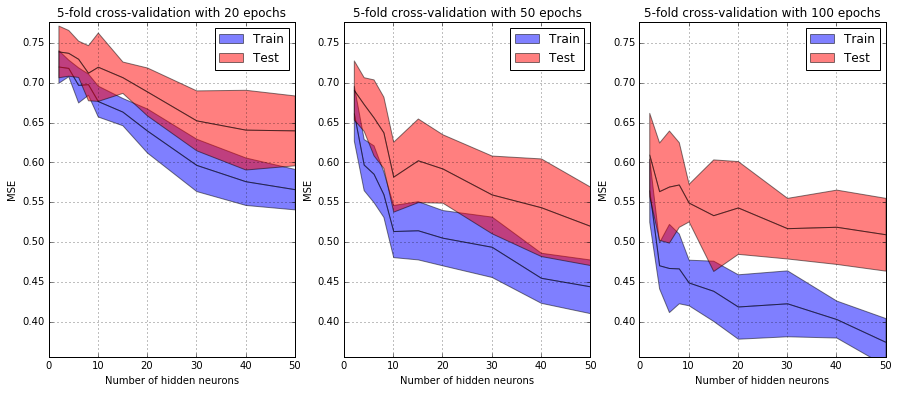

In [182]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

pl.figure(figsize=(15,6))
for i_e, e in enumerate(EPOCHS):
    pl.subplot(1,3,i_e+1)
    pl.fill_between(N_NEURONS, MSE_train_mean[:,i_e], MSE_train_mean[:,i_e]+MSE_train_sd[:,i_e], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(N_NEURONS, MSE_train_mean[:,i_e], MSE_train_mean[:,i_e]-MSE_train_sd[:,i_e], facecolor='blue', alpha=0.5)
    pl.fill_between(N_NEURONS, MSE_test_mean[:,i_e], MSE_test_mean[:,i_e]+MSE_test_sd[:,i_e], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(N_NEURONS, MSE_test_mean[:,i_e], MSE_test_mean[:,i_e]-MSE_test_sd[:,i_e], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,1.05*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of hidden neurons')
    pl.title(str(K)+'-fold cross-validation with '+str(e)+' epochs')
    pl.legend()
    pl.grid()

Tout comme pour le nombre d'epochs, le nombre de neurones n'a vite plus plus d'impact sur la précision.

## Exploring the number of epochs and the number of hidden neurons at the same time

In [183]:
EPOCHS = 100

In [184]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print '\tTesting', h, 'neurons...'
    nn = mlp.MLP([13,h,1], 'tanh')
    temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,
                                                        dataset,
                                                        k=K,
                                                        learning_rate=LEARNING_RATE,
                                                        momentum=MOMENTUM,
                                                        epochs=EPOCHS)
    MSE_train[i_h, :] = temp1
    MSE_test[i_h, :] = temp2

	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...


In [185]:
min(np.min(MSE_train), np.min(MSE_test))

0.35579108874508514

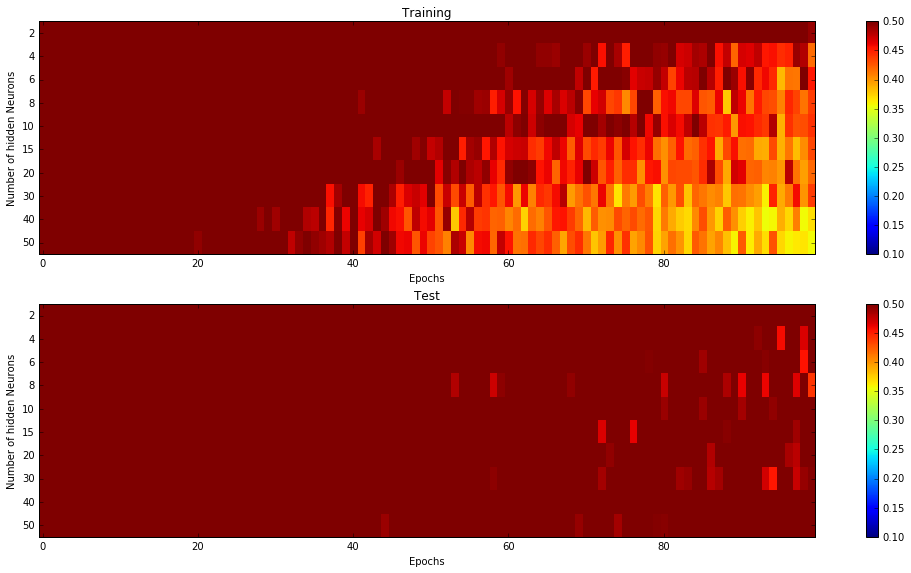

In [186]:
#v_min = min(np.min(MSE_train), np.min(MSE_test))
v_min = 0.1   # tune these values to enhance visualization
v_max = 0.5

pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train, vmin=v_min, vmax=v_max, aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test, vmin=v_min, vmax=v_max, aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

Le faible tau de zones bleu foncé montre qu'il y a relativement beaucoup de faux positifs.

## The final model

In [187]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataset,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=80,
                                                          threshold=0.0)

In [188]:
print 'MSE training: ', MSE_train
print 'MSE test: ', MSE_test
print 'Confusion matrix:'
print conf_mat

MSE training:  0.400570437813
MSE test:  0.526597170673
Confusion matrix:
[[ 23.  13.]
 [ 17.  91.]]


In [189]:
acc = (conf_mat[0][0] + conf_mat[1][1]) / (conf_mat[0][0] + conf_mat[0][1] +conf_mat[1][0] + conf_mat[1][1])
F1 = 2 * conf_mat[0][0] / (2 * conf_mat[0][0] + conf_mat[0][1] + conf_mat[1][0])
print acc
print F1

0.791666666667
0.605263157895


L'erreur est relativement élevée ce qui montre bien qu'une voix de femme est relativement proche d'une voix d'enfant.

# 7.4

In [190]:
dsf = np.array(map(lambda x: np.append(x, 1), nafMeanCeps))
dsm = np.array(map(lambda x: np.append(x, -1), namMeanCeps))
dsk = np.array(map(lambda x: np.append(x, 0), nkMeanCeps))
dataset = np.append(dsf, dsm, axis=0)
dataset = np.append(dataset, dsk, axis=0)
print dataset

[[  1.45192793e+01   2.86848082e+00  -1.53213049e-01 ...,  -3.26818008e-02
    2.52781231e-01   1.00000000e+00]
 [  1.51813605e+01   5.43504237e-01   1.04578408e+00 ...,  -2.53485648e-01
    1.22839214e-01   1.00000000e+00]
 [  1.50093559e+01   2.44551823e+00  -1.00368672e+00 ...,  -1.73233466e-01
    7.12472716e-02   1.00000000e+00]
 ..., 
 [  1.59610437e+01   5.61487637e-01  -6.13341828e-01 ...,  -2.21287010e-01
    2.45052010e-01   0.00000000e+00]
 [  1.61717905e+01   2.20222605e+00   1.40138542e-02 ...,   2.56795112e-01
   -4.55082385e-01   0.00000000e+00]
 [  1.74380068e+01   1.09429176e+00  -2.56215807e-01 ...,  -2.26571466e-01
    2.12672730e-01   0.00000000e+00]]


In [191]:
import mlp_backprop_momentum as mlp
reload(mlp)
import k_fold_cross_validation as cv
reload(cv)

<module 'k_fold_cross_validation' from 'k_fold_cross_validation.pyc'>

In [192]:
N_INITS = 10
EPOCHS = 100
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

In [193]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print 'Testing', h, 'neurons...'
    nn = mlp.MLP([13,h,3], 'tanh')
    for i in np.arange(N_INITS):                                        # looping the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataset[:,0:13], dataset[:,13:15]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


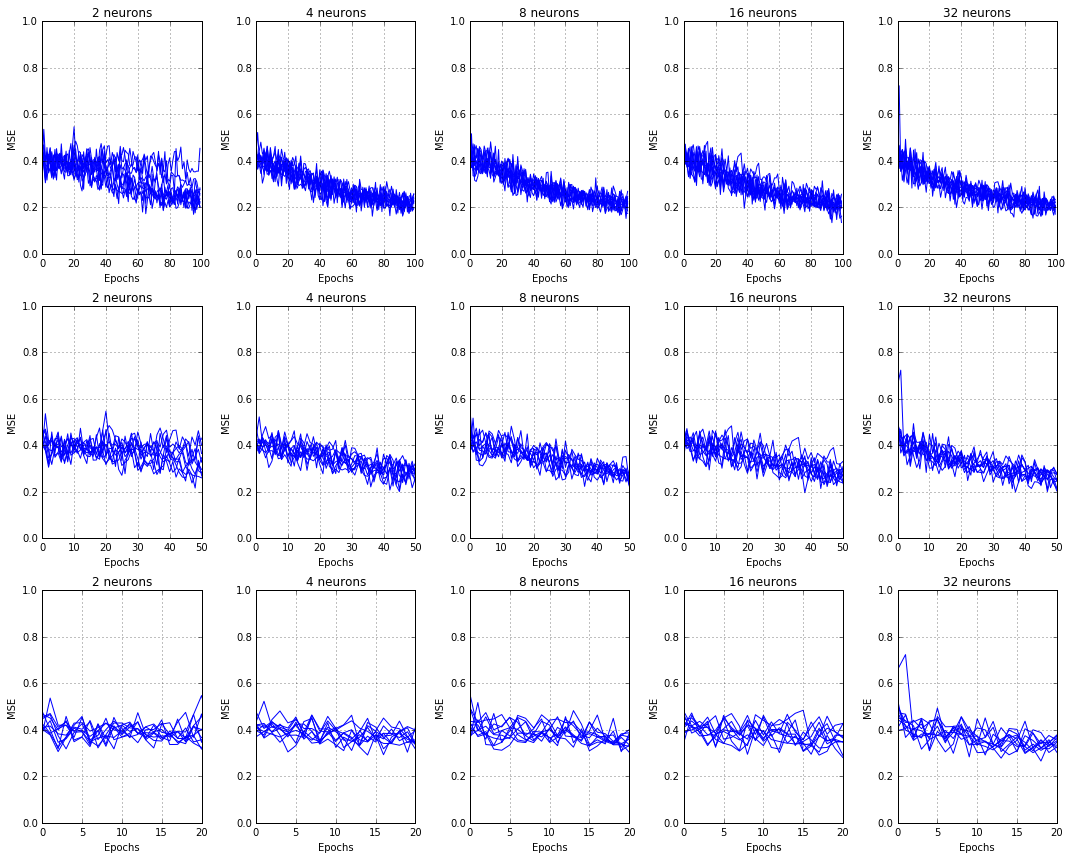

In [194]:
pl.figure(figsize=(15,12))
p_count = 0
for lim in [100, 50, 20]:
    for n in np.arange(MSE.shape[0]):
        p_count += 1
        pl.subplot(3,MSE.shape[0], p_count)
        for i in np.arange(MSE.shape[1]):
            pl.plot(MSE[n,i,:], c='b')
        pl.ylim(0,1)
        pl.xlim(0,lim)
        pl.xlabel('Epochs')
        pl.ylabel('MSE')
        pl.title(str(N_NEURONS[n]) + ' neurons')
        pl.grid()
pl.tight_layout()

In [195]:
EPOCHS = [20, 50, 100]
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 30, 40, 50]

In [196]:
MSE_train = np.zeros((len(N_NEURONS), len(EPOCHS), N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), len(EPOCHS), N_TESTS))

for i_e, e in enumerate(EPOCHS):                                            # looping the number of epochs
    print 'Testing with', e, 'epochs...'
    for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
        print '\tTesting', h, 'neurons...'
        nn = mlp.MLP([13,h,1], 'tanh')
        for i in np.arange(N_TESTS):                                        # looping the tests
            temp1, temp2 = cv.k_fold_cross_validation(nn,
                                                      dataset,
                                                      k=K,
                                                      learning_rate=LEARNING_RATE,
                                                      momentum=MOMENTUM,
                                                      epochs=e)
            MSE_train[i_h, i_e, i] = temp1
            MSE_test[i_h, i_e, i] = temp2

Testing with 20 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...
Testing with 50 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...
Testing with 100 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...


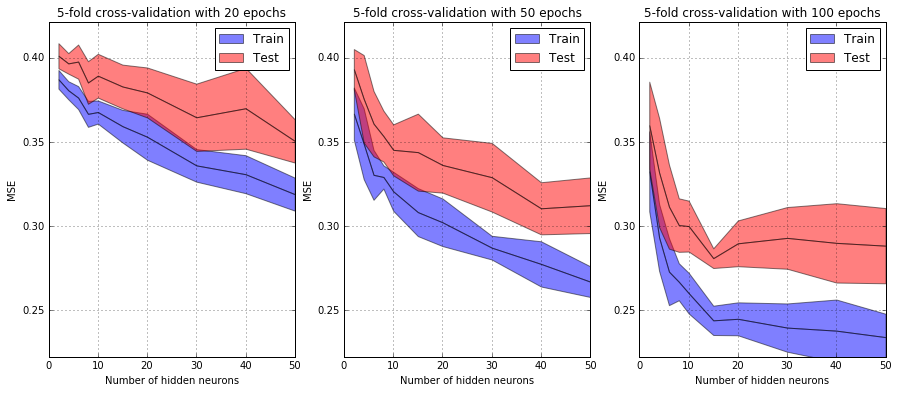

In [197]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

pl.figure(figsize=(15,6))
for i_e, e in enumerate(EPOCHS):
    pl.subplot(1,3,i_e+1)
    pl.fill_between(N_NEURONS, MSE_train_mean[:,i_e], MSE_train_mean[:,i_e]+MSE_train_sd[:,i_e], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(N_NEURONS, MSE_train_mean[:,i_e], MSE_train_mean[:,i_e]-MSE_train_sd[:,i_e], facecolor='blue', alpha=0.5)
    pl.fill_between(N_NEURONS, MSE_test_mean[:,i_e], MSE_test_mean[:,i_e]+MSE_test_sd[:,i_e], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(N_NEURONS, MSE_test_mean[:,i_e], MSE_test_mean[:,i_e]-MSE_test_sd[:,i_e], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,1.05*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of hidden neurons')
    pl.title(str(K)+'-fold cross-validation with '+str(e)+' epochs')
    pl.legend()
    pl.grid()

## Exploring the number of epochs and the number of hidden neurons at the same time

In [198]:
EPOCHS = 100

In [199]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print '\tTesting', h, 'neurons...'
    nn = mlp.MLP([13,h,1], 'tanh')
    temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,
                                                        dataset,
                                                        k=K,
                                                        learning_rate=LEARNING_RATE,
                                                        momentum=MOMENTUM,
                                                        epochs=EPOCHS)
    MSE_train[i_h, :] = temp1
    MSE_test[i_h, :] = temp2

	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...


In [200]:
min(np.min(MSE_train), np.min(MSE_test))

0.20325893314039362

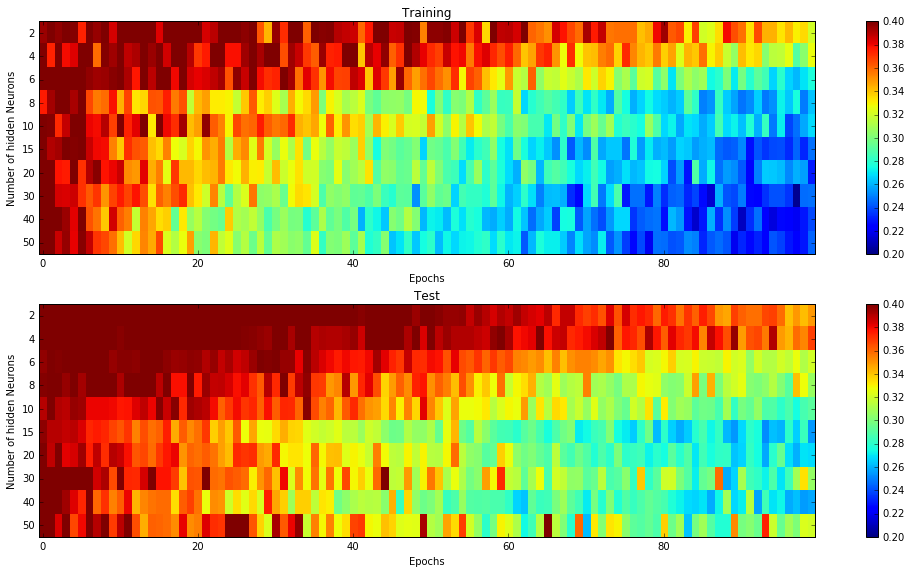

In [201]:
#v_min = min(np.min(MSE_train), np.min(MSE_test))
v_min = 0.2   # tune these values to enhance visualization
v_max = 0.4

pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train, vmin=v_min, vmax=v_max, aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test, vmin=v_min, vmax=v_max, aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

## The final model

In [202]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataset,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=80,
                                                          threshold=0.0)

In [203]:
print 'MSE training: ', MSE_train
print 'MSE test: ', MSE_test
print 'Confusion matrix:'
print conf_mat

MSE training:  0.230503941701
MSE test:  0.257890628832
Confusion matrix:
[[ 30.   6.]
 [ 64.  80.]]


In [204]:
acc = (conf_mat[0][0] + conf_mat[1][1]) / (conf_mat[0][0] + conf_mat[0][1] +conf_mat[1][0] + conf_mat[1][1])
F1 = 2 * conf_mat[0][0] / (2 * conf_mat[0][0] + conf_mat[0][1] + conf_mat[1][0])
print acc
print F1

0.611111111111
0.461538461538


# 7.5

In [205]:
naturalFiles = []
synthesizedFiles = []

for f in files:
    if "n" in f:
        naturalFiles.append(wav.read(BASE_DIR + f))
    if "s" in f:
        synthesizedFiles.append(wav.read(BASE_DIR + f))

In [206]:
naturalCeps = []
for f in naturalFiles:
    naturalCeps.append(mfcc(f[1], fs=f[0])[0])

synthesizedCeps = []
for f in synthesizedFiles:
    synthesizedCeps.append(mfcc(f[1], fs=f[0])[0])

In [207]:
naturalMeanCeps = []
for c in naturalCeps:
    naturalMeanCeps.append(np.mean(c, axis=0))

In [208]:
synthesizedMeanCeps = []
for c in synthesizedCeps:
    synthesizedMeanCeps.append(np.mean(c, axis=0))

In [209]:
dsf = np.array(map(lambda x: np.append(x, 1), naturalMeanCeps))
dsm = np.array(map(lambda x: np.append(x, -1), synthesizedMeanCeps))
dataset = np.append(dsf, dsm, axis=0)

In [210]:
N_INITS = 10
EPOCHS = 100
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

In [211]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print 'Testing', h, 'neurons...'
    nn = mlp.MLP([13,h,2], 'tanh')
    for i in np.arange(N_INITS):                                        # looping the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataset[:,0:13], dataset[:,13:15]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


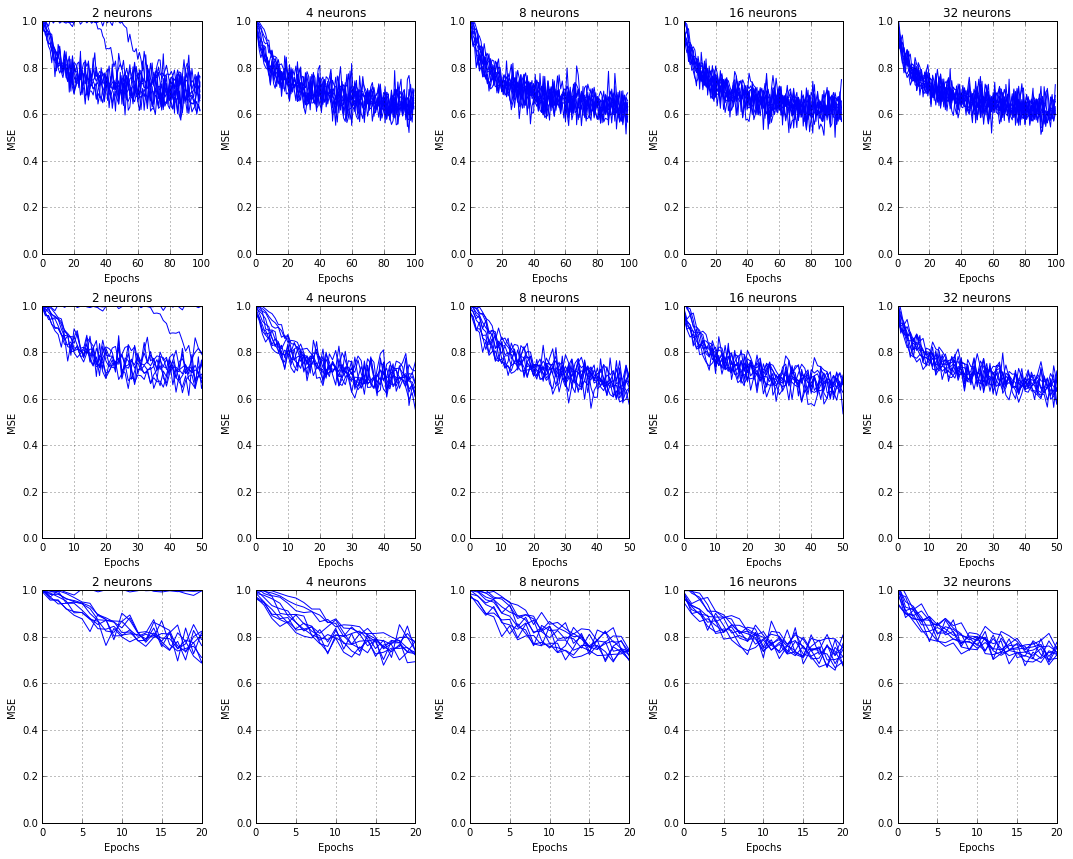

In [212]:
pl.figure(figsize=(15,12))
p_count = 0
for lim in [100, 50, 20]:
    for n in np.arange(MSE.shape[0]):
        p_count += 1
        pl.subplot(3,MSE.shape[0], p_count)
        for i in np.arange(MSE.shape[1]):
            pl.plot(MSE[n,i,:], c='b')
        pl.ylim(0,1)
        pl.xlim(0,lim)
        pl.xlabel('Epochs')
        pl.ylabel('MSE')
        pl.title(str(N_NEURONS[n]) + ' neurons')
        pl.grid()
pl.tight_layout()

Le nombre d'epochs a peut d'influence sur l'erreur, à 50 epochs les résultats sont à peine meilleurs qu'à 20 epochs.

## Exploring the number of hidden neurons

In [213]:
EPOCHS = [20, 50, 100]
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 30, 40, 50]

In [214]:
MSE_train = np.zeros((len(N_NEURONS), len(EPOCHS), N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), len(EPOCHS), N_TESTS))

for i_e, e in enumerate(EPOCHS):                                            # looping the number of epochs
    print 'Testing with', e, 'epochs...'
    for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
        print '\tTesting', h, 'neurons...'
        nn = mlp.MLP([13,h,1], 'tanh')
        for i in np.arange(N_TESTS):                                        # looping the tests
            temp1, temp2 = cv.k_fold_cross_validation(nn,
                                                      dataset,
                                                      k=K,
                                                      learning_rate=LEARNING_RATE,
                                                      momentum=MOMENTUM,
                                                      epochs=e)
            MSE_train[i_h, i_e, i] = temp1
            MSE_test[i_h, i_e, i] = temp2

Testing with 20 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...
Testing with 50 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...
Testing with 100 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...


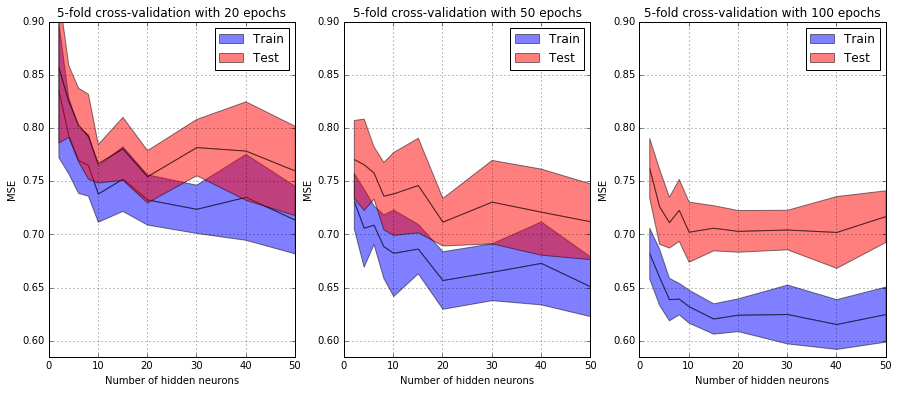

In [215]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

pl.figure(figsize=(15,6))
for i_e, e in enumerate(EPOCHS):
    pl.subplot(1,3,i_e+1)
    pl.fill_between(N_NEURONS, MSE_train_mean[:,i_e], MSE_train_mean[:,i_e]+MSE_train_sd[:,i_e], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(N_NEURONS, MSE_train_mean[:,i_e], MSE_train_mean[:,i_e]-MSE_train_sd[:,i_e], facecolor='blue', alpha=0.5)
    pl.fill_between(N_NEURONS, MSE_test_mean[:,i_e], MSE_test_mean[:,i_e]+MSE_test_sd[:,i_e], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(N_NEURONS, MSE_test_mean[:,i_e], MSE_test_mean[:,i_e]-MSE_test_sd[:,i_e], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,1.05*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of hidden neurons')
    pl.title(str(K)+'-fold cross-validation with '+str(e)+' epochs')
    pl.legend()
    pl.grid()

## Exploring the number of epochs and the number of hidden neurons at the same time

In [216]:
EPOCHS = 100

In [217]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print '\tTesting', h, 'neurons...'
    nn = mlp.MLP([13,h,1], 'tanh')
    temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,
                                                        dataset,
                                                        k=K,
                                                        learning_rate=LEARNING_RATE,
                                                        momentum=MOMENTUM,
                                                        epochs=EPOCHS)
    MSE_train[i_h, :] = temp1
    MSE_test[i_h, :] = temp2

	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...


In [218]:
min(np.min(MSE_train), np.min(MSE_test))

0.56619052661638236

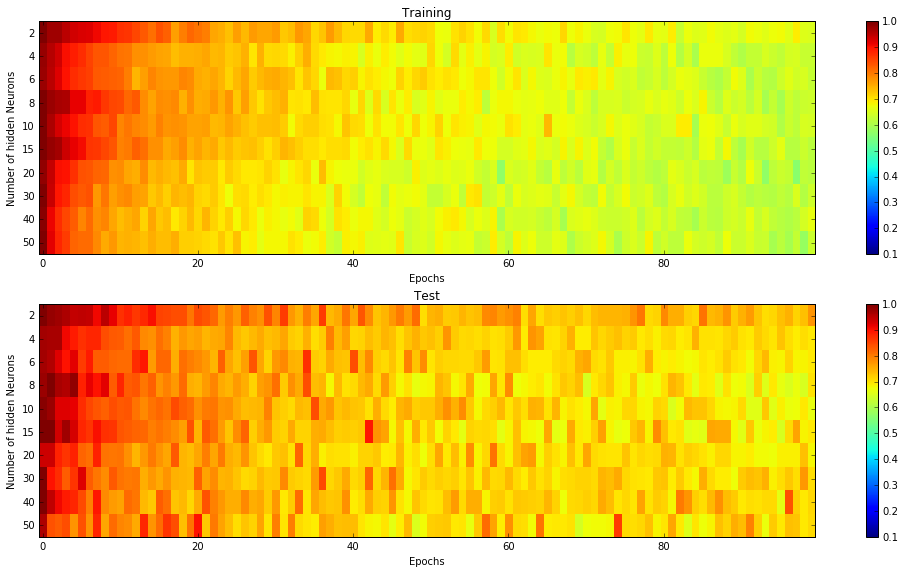

In [219]:
#v_min = min(np.min(MSE_train), np.min(MSE_test))
v_min = 0.1   # tune these values to enhance visualization
v_max = 1

pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train, vmin=v_min, vmax=v_max, aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test, vmin=v_min, vmax=v_max, aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

On observe un grand pic d'erreur à 8 neurones.

## The final model

In [220]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataset,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=80,
                                                          threshold=0.0)

In [221]:
print 'MSE training: ', MSE_train
print 'MSE test: ', MSE_test
print 'Confusion matrix:'
print conf_mat

MSE training:  0.628467085396
MSE test:  0.69932638162
Confusion matrix:
[[ 158.   34.]
 [  72.  144.]]


In [222]:
acc = (conf_mat[0][0] + conf_mat[1][1]) / (conf_mat[0][0] + conf_mat[0][1] +conf_mat[1][0] + conf_mat[1][1])
F1 = 2 * conf_mat[0][0] / (2 * conf_mat[0][0] + conf_mat[0][1] + conf_mat[1][0])
print acc
print F1

0.740196078431
0.748815165877


l'erreur est très élevée ce qui signifie qu'il est très dur de départager les données.

# 7.6

Le but ici est de voir à quel point le réseau de neurones arrive à distinguer des échantillons très proches, en prenant des enfants de 3 et 7 ans.

In [223]:
_3yoFiles = []
_7yoFiles = []

for f in files:
    if f.startswith("nk3"):
        _3yoFiles.append(wav.read(BASE_DIR + f))
    if f.startswith("nk7"):
        _7yoFiles.append(wav.read(BASE_DIR + f))

In [224]:
_3yoCeps = []
for f in _3yoFiles:
    _3yoCeps.append(mfcc(f[1], fs=f[0])[0])

_7yoCeps = []
for f in _7yoFiles:
    _7yoCeps.append(mfcc(f[1], fs=f[0])[0])

In [225]:
_3yoMeanCeps = []
for c in naturalCeps:
    _3yoMeanCeps.append(np.mean(c, axis=0))

In [226]:
_7yoMeanCeps = []
for c in naturalCeps:
    _7yoMeanCeps.append(np.mean(c, axis=0))

In [227]:
dsf = np.array(map(lambda x: np.append(x, 1), _3yoMeanCeps))
dsm = np.array(map(lambda x: np.append(x, -1), _7yoMeanCeps))
dataset = np.append(dsf, dsm, axis=0)

In [228]:
N_INITS = 10
EPOCHS = 100
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

In [229]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print 'Testing', h, 'neurons...'
    nn = mlp.MLP([13,h,2], 'tanh')
    for i in np.arange(N_INITS):                                        # looping the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataset[:,0:13], dataset[:,13:15]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


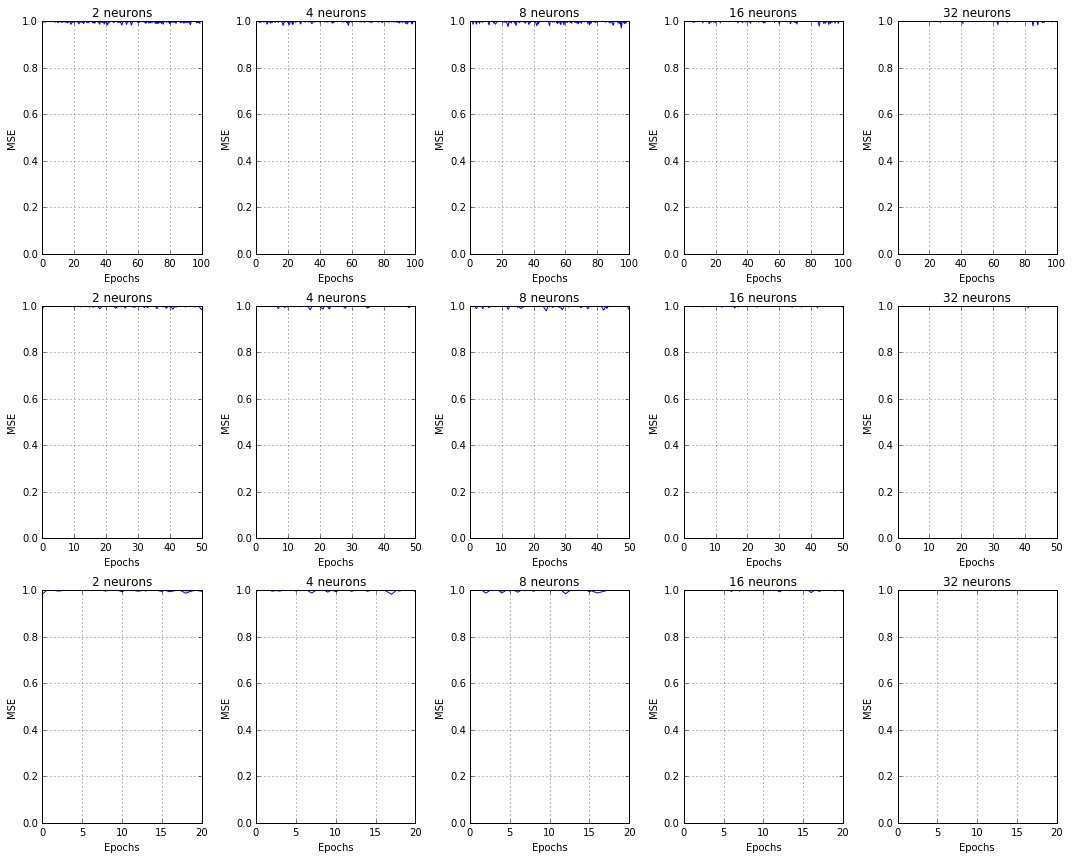

In [230]:
pl.figure(figsize=(15,12))
p_count = 0
for lim in [100, 50, 20]:
    for n in np.arange(MSE.shape[0]):
        p_count += 1
        pl.subplot(3,MSE.shape[0], p_count)
        for i in np.arange(MSE.shape[1]):
            pl.plot(MSE[n,i,:], c='b')
        pl.ylim(0,1)
        pl.xlim(0,lim)
        pl.xlabel('Epochs')
        pl.ylabel('MSE')
        pl.title(str(N_NEURONS[n]) + ' neurons')
        pl.grid()
pl.tight_layout()

La variation d'epochs n'a aucune influence.

## Exploring the number of hidden neurons

In [231]:
EPOCHS = [20, 50, 100]
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 30, 40, 50]

In [232]:
MSE_train = np.zeros((len(N_NEURONS), len(EPOCHS), N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), len(EPOCHS), N_TESTS))

for i_e, e in enumerate(EPOCHS):                                            # looping the number of epochs
    print 'Testing with', e, 'epochs...'
    for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
        print '\tTesting', h, 'neurons...'
        nn = mlp.MLP([13,h,1], 'tanh')
        for i in np.arange(N_TESTS):                                        # looping the tests
            temp1, temp2 = cv.k_fold_cross_validation(nn,
                                                      dataset,
                                                      k=K,
                                                      learning_rate=LEARNING_RATE,
                                                      momentum=MOMENTUM,
                                                      epochs=e)
            MSE_train[i_h, i_e, i] = temp1
            MSE_test[i_h, i_e, i] = temp2

Testing with 20 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...
Testing with 50 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...
Testing with 100 epochs...
	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...


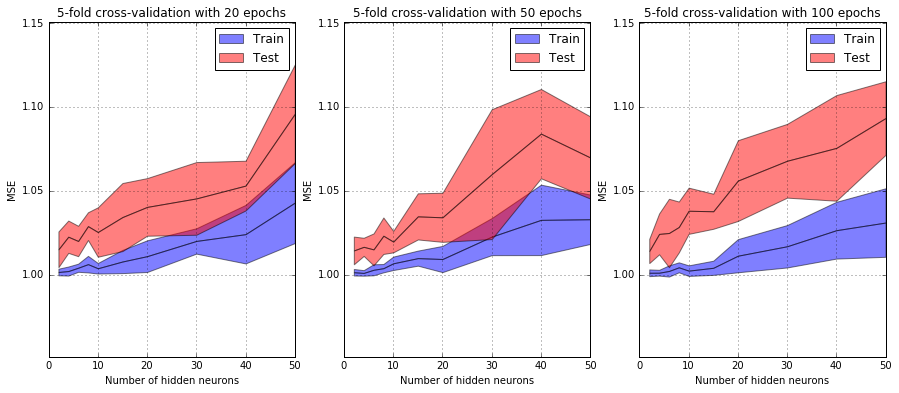

In [233]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

pl.figure(figsize=(15,6))
for i_e, e in enumerate(EPOCHS):
    pl.subplot(1,3,i_e+1)
    pl.fill_between(N_NEURONS, MSE_train_mean[:,i_e], MSE_train_mean[:,i_e]+MSE_train_sd[:,i_e], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(N_NEURONS, MSE_train_mean[:,i_e], MSE_train_mean[:,i_e]-MSE_train_sd[:,i_e], facecolor='blue', alpha=0.5)
    pl.fill_between(N_NEURONS, MSE_test_mean[:,i_e], MSE_test_mean[:,i_e]+MSE_test_sd[:,i_e], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(N_NEURONS, MSE_test_mean[:,i_e], MSE_test_mean[:,i_e]-MSE_test_sd[:,i_e], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,1.05*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of hidden neurons')
    pl.title(str(K)+'-fold cross-validation with '+str(e)+' epochs')
    pl.legend()
    pl.grid()

Nous ne pouvons évitement rien tirer de ces graphes car les erreurs sont trop importantes.

## Exploring the number of epochs and the number of hidden neurons at the same time

In [246]:
EPOCHS = 100

In [247]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print '\tTesting', h, 'neurons...'
    nn = mlp.MLP([13,h,1], 'tanh')
    temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,
                                                        dataset,
                                                        k=K,
                                                        learning_rate=LEARNING_RATE,
                                                        momentum=MOMENTUM,
                                                        epochs=EPOCHS)
    MSE_train[i_h, :] = temp1
    MSE_test[i_h, :] = temp2

	Testing 2 neurons...
	Testing 4 neurons...
	Testing 6 neurons...
	Testing 8 neurons...
	Testing 10 neurons...
	Testing 15 neurons...
	Testing 20 neurons...
	Testing 30 neurons...
	Testing 40 neurons...
	Testing 50 neurons...


In [248]:
min(np.min(MSE_train), np.min(MSE_test))

0.99259420751129657

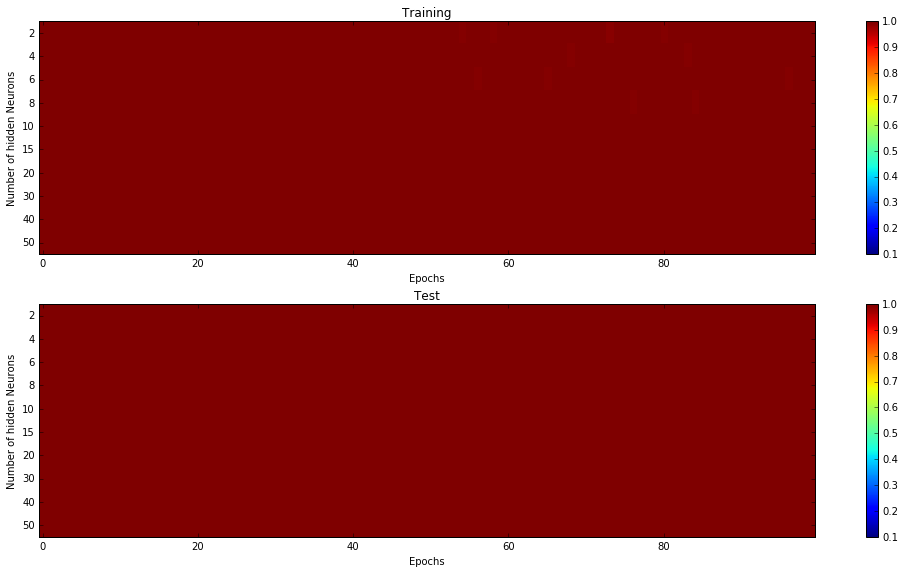

In [249]:
#v_min = min(np.min(MSE_train), np.min(MSE_test))
v_min = 0.1   # tune these values to enhance visualization
v_max = 1

pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train, vmin=v_min, vmax=v_max, aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test, vmin=v_min, vmax=v_max, aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

On voit que le réseau de neurones n'arrive rien à distinguer.

## The final model

In [250]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataset,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=80,
                                                          threshold=0.0)

In [251]:
print 'MSE training: ', MSE_train
print 'MSE test: ', MSE_test
print 'Confusion matrix:'
print conf_mat

MSE training:  1.06636665846
MSE test:  1.13705324908
Confusion matrix:
[[ 116.   76.]
 [ 126.   66.]]


In [252]:
acc = (conf_mat[0][0] + conf_mat[1][1]) / (conf_mat[0][0] + conf_mat[0][1] +conf_mat[1][0] + conf_mat[1][1])
F1 = 2 * conf_mat[0][0] / (2 * conf_mat[0][0] + conf_mat[0][1] + conf_mat[1][0])
print acc
print F1

0.473958333333
0.534562211982


Comme on pouvait s'en douter, sur un set de données ou même l'oreille humaine a de la peine, un réseau de neurones n'a aucune chance de trouver quoi que ce soit. Ceci peut être partiellement dû au fait que le mfcc ne décrit peut-être pas assez précisément les sons pour une telle application, et qu'il manque donc de feature.